In [24]:
param_window_size = 24
param_seq_length = 287
param_num_epoch = 100
param_lstm_units = 128
param_lstm_stack = 1

num_sample = param_seq_length - param_window_size

In [25]:
import numpy as np
import os
import pandas
import theano

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def diff_dataset(dataset):
    diff = np.zeros((dataset.shape[0]-1, 1))
    for i in range(dataset.shape[0]-1):
        diff[i] = dataset[i,0]-dataset[i+1,0]
    return diff

def reverse_diff_dataset(diff, init_value):
    reverse = np.zeros((diff.shape[0]+1, 1))
    reverse[0] = init_value
    for i in range(diff.shape[0]):
        reverse[i+1] = reverse[i] - diff[i]    
    return reverse

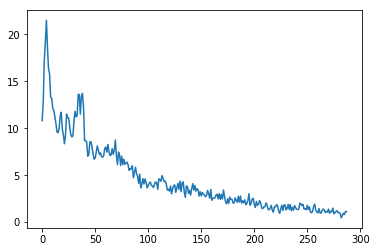

In [26]:
dataset_file_path = './Data_RNN/201601.txt'
df = pandas.read_csv(dataset_file_path, delim_whitespace=True, header=None, usecols=[6])

# dataframe to dataset
dataset = df.values
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

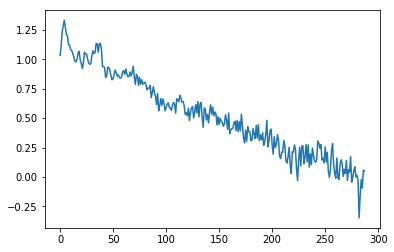

In [27]:
dataset_log = np.log10(dataset) # stationary signal
#dataset = np.diff(dataset, n=1, axis=0) # detrended signa

dataset_diff = diff_dataset(lot)

plt.plot(dataset)
plt.plot(dataset_log)
plt.plot(dataset_diff)
plt.show()

dataset = dataset_diff
reverse = reverse_diff_dataset(diff, dataset[0,0])

plt.plot(dataset)
plt.plot(diff)
plt.plot(reverse)

plt.show()


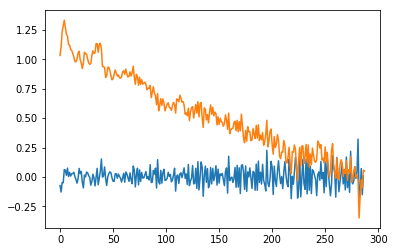

In [10]:
trainX, trainY = create_dataset(dataset, param_window_size)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX, testY = create_dataset(dataset, param_window_size)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [11]:
trainX.shape

(263, 24, 1)

In [12]:
%%time

theano.config.compute_test_value = "ignore"

model = Sequential()
for i in range(param_lstm_stack):
    model.add(LSTM(param_lstm_units, batch_input_shape=(1, param_window_size, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(param_lstm_units, batch_input_shape=(1, param_window_size, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

CPU times: user 665 ms, sys: 68.1 ms, total: 734 ms
Wall time: 853 ms


In [13]:
for epoch_idx in range(param_num_epoch):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
3s - loss: 0.0073
epochs : 1
Epoch 1/1
2s - loss: 0.0063
epochs : 2
Epoch 1/1
2s - loss: 0.0065
epochs : 3
Epoch 1/1
2s - loss: 0.0061
epochs : 4
Epoch 1/1
2s - loss: 0.0059
epochs : 5
Epoch 1/1
2s - loss: 0.0061
epochs : 6
Epoch 1/1
2s - loss: 0.0059
epochs : 7
Epoch 1/1
2s - loss: 0.0058
epochs : 8
Epoch 1/1
2s - loss: 0.0058
epochs : 9
Epoch 1/1
2s - loss: 0.0059
epochs : 10
Epoch 1/1
2s - loss: 0.0057
epochs : 11
Epoch 1/1
2s - loss: 0.0056
epochs : 12
Epoch 1/1
2s - loss: 0.0055
epochs : 13
Epoch 1/1
2s - loss: 0.0061
epochs : 14
Epoch 1/1
2s - loss: 0.0057
epochs : 15
Epoch 1/1
2s - loss: 0.0059
epochs : 16
Epoch 1/1
2s - loss: 0.0057
epochs : 17
Epoch 1/1
2s - loss: 0.0054
epochs : 18
Epoch 1/1
2s - loss: 0.0057
epochs : 19
Epoch 1/1
2s - loss: 0.0056
epochs : 20
Epoch 1/1
2s - loss: 0.0055
epochs : 21
Epoch 1/1
2s - loss: 0.0056
epochs : 22
Epoch 1/1
2s - loss: 0.0056
epochs : 23
Epoch 1/1
2s - loss: 0.0057
epochs : 24
Epoch 1/1
2s - loss: 0.0056
epochs : 2

In [14]:
testScore = model.evaluate(testX, testY, batch_size=1, verbose=0)
print('Test Score: ', testScore)

model.reset_states()

('Test Score: ', 0.005059698467703962)


In [15]:
testX[1][:]
testY[0]

testPredict = [np.vstack([testX[0][:]])]

In [16]:
testPredict[-1]

array([[ 0.07378614],
       [ 0.12831855],
       [ 0.04777277],
       [ 0.04913723],
       [-0.06292546],
       [-0.05732548],
       [-0.01353049],
       [-0.07480538],
       [-0.00327778],
       [-0.03778851],
       [-0.00723839],
       [-0.02632892],
       [-0.02802873],
       [-0.03937072],
       [-0.00318164],
       [ 0.02136302],
       [ 0.05307841],
       [ 0.01510739],
       [-0.07211214],
       [-0.02805793],
       [-0.04632926],
       [ 0.04539329],
       [ 0.09361804],
       [-0.01537478]], dtype=float32)

In [17]:
a = np.vstack([testPredict[-1][1:],0.66])

In [18]:
testPredict[-1][1:]

array([[ 0.12831855],
       [ 0.04777277],
       [ 0.04913723],
       [-0.06292546],
       [-0.05732548],
       [-0.01353049],
       [-0.07480538],
       [-0.00327778],
       [-0.03778851],
       [-0.00723839],
       [-0.02632892],
       [-0.02802873],
       [-0.03937072],
       [-0.00318164],
       [ 0.02136302],
       [ 0.05307841],
       [ 0.01510739],
       [-0.07211214],
       [-0.02805793],
       [-0.04632926],
       [ 0.04539329],
       [ 0.09361804],
       [-0.01537478]], dtype=float32)

In [19]:
test_seq_size = param_seq_length - param_window_size
curr_idx = 100

predictions = np.zeros((test_seq_size, 1))
testPredict = [np.vstack([testX[0][:]])]

look_hist = curr_idx
look_ahead = test_seq_size - curr_idx

for i in range(look_hist):
    prediction = model.predict(np.array([testPredict[-1]]), batch_size=1)
    predictions[i] = testY[i]
    testPredict.append(np.vstack([testX[i+1][:]]))

for i in range(look_ahead):    
    prediction = model.predict(np.array([testPredict[-1]]), batch_size=1)
    predictions[i + look_hist] = prediction
    testPredict.append(np.vstack([testPredict[-1][1:],prediction]))

model.reset_states()

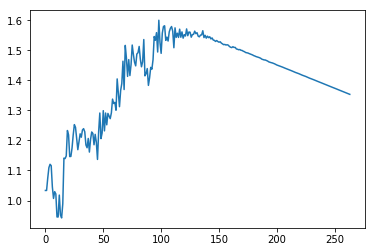

In [56]:

view = reverse_diff_dataset(predictions, dataset[0,0])

plt.plot(view)
plt.show()

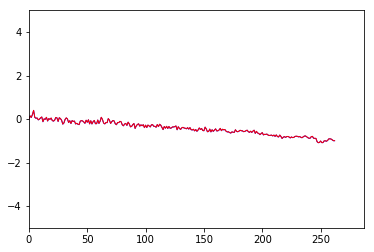

In [23]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 287), ylim=(-5, 5))

plotcols = ["blue","red"]

lines = []

test_seq_size = param_seq_length - param_window_size
    
for i in range(2):
    lobj = ax.plot([],[],lw=1,color=plotcols[i])[0]
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(curr_idx):

    predictions = np.zeros((test_seq_size, 1))
    testPredict = [np.vstack([testX[0][:]])]

    look_hist = curr_idx
    look_ahead = test_seq_size - curr_idx

    for i in range(look_hist):
        prediction = model.predict(np.array([testPredict[-1]]), batch_size=1)
        predictions[i] = testY[i]
        testPredict.append(np.vstack([testX[i+1][:]]))
        
    for i in range(look_ahead):    
        prediction = model.predict(np.array([testPredict[-1]]), batch_size=1)
        predictions[i + look_hist] = prediction
        testPredict.append(np.vstack([testPredict[-1][1:],prediction]))
    
    model.reset_states()
    
    x = np.linspace(0, test_seq_size-1, test_seq_size)
    
    testY_view = np.cumsum(testY[::-1])[::1] 
    testY_view = np.reshape(testY_view, (num_sample,1))    

    predictions_view = np.cumsum(predictions[::-1])[::1] 
    predictions_view = np.reshape(predictions_view, (num_sample,1))    
    
    y = [testY_view, predictions_view]
    
    #for index in range(0,1):
    for i, line in enumerate(lines):
        line.set_data(x, y[i]) # set data for each line separately. 

    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=test_seq_size, interval=20, blit=True)

result_filename = 'w' + str(param_window_size) + '_' + 'u' + str(param_lstm_units) + '_' + 's' + str(param_lstm_stack) + '_' + 'e' + str(param_num_epoch)

anim.save( result_filename + '.gif', writer='imagemagick', fps=30, dpi=100)

plt.show()